In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import torch.nn as nn
import cv2
from keras import Model
from PIL import Image
from tensorflow.keras import layers,models
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout
from sklearn.model_selection import train_test_split
DIRNAME = '/kaggle/input/iitgai-ovha-23/images/'
SIZE = 256
SAMPLE_NUM = 1800


def show(img):
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()




def showImgBBox(img,label):
    plt.imshow(img)
    plt.axis('off')
    x1,y1,x2,y2,x3,y3,x4,y4 = label
    pt1_x= [x1,x2]
    pt1_y= [y1,y2]
    pt2_x= [x2,x3]
    pt2_y = [y2,y3]
    pt3_x = [x3,x4]
    pt3_y = [y3,y4]
    pt4_x = [x4,x1]
    pt4_y = [y4,y1]
    plt.plot(pt1_x,pt1_y,color='white')
    plt.plot(pt2_x,pt2_y,color='white')
    plt.plot(pt3_x,pt3_y,color='white')
    plt.plot(pt4_x,pt4_y,color='white')
    plt.show()

    
df = pd.read_csv('/kaggle/input/iitgai-ovha-23/train_labels.csv')
df.head()
numdf = df.to_numpy()
directory = '/kaggle/input/iitgai-ovha-23/images/'

X = []
Y = []


In [22]:
def build_model(input_layer, start_neurons):
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

input_layer = Input((SIZE,SIZE, 1))
output_layer = build_model(input_layer, 16)

In [23]:
width = 1280
height = 720

def dataloader(pair):
    impath = pair[0]
    imlabel = pair[1]
    img = cv2.imread(directory + impath)
    imlabel = imlabel[1:len(imlabel)-1]
    imlabel = imlabel.split(',')
    processed = [int(float(num)) for num in imlabel]
    x1,y1,x2,y2,x3,y3,x4,y4 = processed
    img = cv2.resize(img, (SIZE,SIZE))
    x1 *= (SIZE/width)
    x2 *= (SIZE/width)
    x3 *= (SIZE/width)
    x4 *= (SIZE/width)
    y1 *= (SIZE/height)
    y2 *= (SIZE/height)
    y3 *= (SIZE/height)
    y4 *= (SIZE/height)
    points = np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]], np.int32)
    binary_image = np.zeros((SIZE,SIZE), dtype=np.float32)
    img = img.astype(np.float32)
    img *= (1.0/255.0)
    img = img.mean(axis=2)
    cv2.fillPoly(binary_image, [points], 255)
    binary_image/=255
    X.append(img)
    Y.append(binary_image.astype(bool))
    

In [24]:
for pair in numdf:
    dataloader(pair)

'for pair in numdf:\n    dataloader(pair)'

In [25]:
X = np.array(X)
Y = np.array(Y)

In [26]:
X.shape

(0,)

In [27]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.05,random_state=42)

'X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.05,random_state=42)'

In [28]:
from keras.models import load_model

model = load_model('/kaggle/working/UNET_Model_2.h5')

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

model.compile(optimizer='adam', metrics='accuracy', loss='binary_crossentropy')

early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./UNET_Model_2.h5", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

epochs = 200
batch_size = 32

'from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau\n\nmodel.compile(optimizer=\'adam\', metrics=\'accuracy\', loss=\'binary_crossentropy\')\n\nearly_stopping = EarlyStopping(patience=10, verbose=1)\nmodel_checkpoint = ModelCheckpoint("./UNET_Model_2.h5", save_best_only=True, verbose=1)\nreduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)\n\nepochs = 200\nbatch_size = 32'

In [31]:
history = model.fit(X_train, Y_train,
                    validation_data=[X_test, Y_test], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

'history = model.fit(X_train, Y_train,\n                    validation_data=[X_test, Y_test], \n                    epochs=epochs,\n                    batch_size=batch_size,\n                    callbacks=[early_stopping, model_checkpoint, reduce_lr])'

In [32]:
img = X[17]
show(img)
img = np.expand_dims(img,axis=0)
img.shape
prediction = model.predict(img)
show(prediction[0])


'img = X[17]\nshow(img)\nimg = np.expand_dims(img,axis=0)\nimg.shape\nprediction = model.predict(img)\nshow(prediction[0])\n'

In [33]:
X_new = []
Y_new = []
def dataloader2(img,label):
    img = np.expand_dims(img, axis=0)
    preds = model.predict(img)
    X_new.append(preds[0])
    label = label[1:-1]
    label = label.split(',')
    processed = [int(float(num)) for num in label]
    Y_new.append(processed)
    

In [34]:
for i in range(1800):
    dataloader2(X[i],numdf[i][1])

'for i in range(1800):\n    dataloader2(X[i],numdf[i][1])'

In [35]:
X_new = np.array(X_new)
Y_new = np.array(Y_new)

X_new.shape

'X_new = np.array(X_new)\nY_new = np.array(Y_new)\n\nX_new.shape'

In [36]:
cnn = models.Sequential([
    layers.Conv2D(filters=16,activation='relu',kernel_size=(3,3), input_shape=(SIZE,SIZE,1),padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=16,activation='relu',kernel_size=(3,3),padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=8,activation='relu',kernel_size=(3,3),padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(32,activation='relu'),
    layers.Dense(8,activation='relu')
])

"cnn = models.Sequential([\n    layers.Conv2D(filters=16,activation='relu',kernel_size=(3,3), input_shape=(SIZE,SIZE,1),padding='same'),\n    layers.MaxPooling2D((2,2)),\n    layers.Conv2D(filters=16,activation='relu',kernel_size=(3,3),padding='same'),\n    layers.MaxPooling2D((2,2)),\n    layers.Conv2D(filters=8,activation='relu',kernel_size=(3,3),padding='same'),\n    layers.MaxPooling2D((2,2)),\n    layers.Flatten(),\n    layers.Dense(128,activation='relu'),\n    layers.Dense(32,activation='relu'),\n    layers.Dense(8,activation='relu')\n])"

In [37]:
cnn = load_model('/kaggle/working/LabelFinder.h5')

In [38]:
cnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 128, 128, 16)      2320      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 64, 64, 8)         1160      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 32, 32, 8)       

In [39]:
from tensorflow.keras.losses import MeanSquaredError
cnn.compile(optimizer='adam', metrics='accuracy', loss=MeanSquaredError())

early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./LabelFinder.h5", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
epochs = 300
batch_size = 32

'from tensorflow.keras.losses import MeanSquaredError\ncnn.compile(optimizer=\'adam\', metrics=\'accuracy\', loss=MeanSquaredError())\n\nearly_stopping = EarlyStopping(patience=10, verbose=1)\nmodel_checkpoint = ModelCheckpoint("./LabelFinder.h5", save_best_only=True, verbose=1)\nreduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)\nepochs = 300\nbatch_size = 32'

In [40]:
X_new_train,X_new_val,Y_new_train,Y_new_val = train_test_split(X_new,Y_new, test_size=0.05,random_state=34)

'X_new_train,X_new_val,Y_new_train,Y_new_val = train_test_split(X_new,Y_new, test_size=0.05,random_state=34)'

In [41]:
cnn.fit(X_new_train,Y_new_train, validation_data=[X_new_val,Y_new_val], batch_size=batch_size, epochs=epochs, callbacks=[early_stopping,model_checkpoint,reduce_lr])

'cnn.fit(X_new_train,Y_new_train, validation_data=[X_new_val,Y_new_val], batch_size=batch_size, epochs=epochs, callbacks=[early_stopping,model_checkpoint,reduce_lr])'

In [42]:
import gc
gc.collect()

15261

In [47]:
def display_imgs(path):
    img = cv2.imread(path)
    original = img.copy()
    img = cv2.resize(img, (SIZE,SIZE))
    show(img)
    img = img.astype(np.float32)
    img *= (1.0/255.0)
    img = img.mean(axis=2)
    img = np.expand_dims(img, axis=0)
    mask = model.predict(img)[0]
    show(mask)
    mask = np.expand_dims(mask,axis=0)
    predictions = cnn.predict(mask)[0]
    bin_mask = np.zeros(original.shape)
    label = [int(num) for num in predictions]
    x1,y1,x2,y2,x3,y3,x4,y4 = label
    points = np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]], np.int32)
    cv2.fillPoly(bin_mask, [points], 255)
    bin_mask/=255
    show(original)
    show(bin_mask)
    showImgBBox(original,label)
    
    

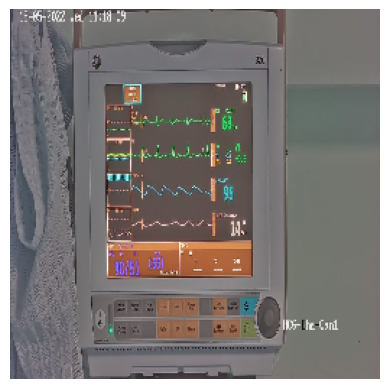

1/1 [==============================] - 0s 23ms/step


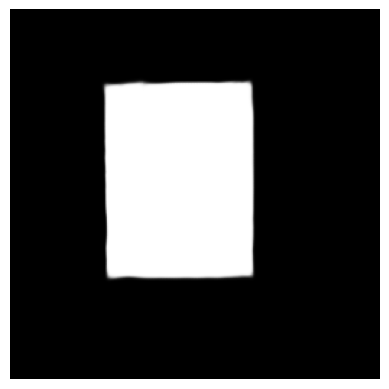

1/1 [==============================] - 0s 32ms/step


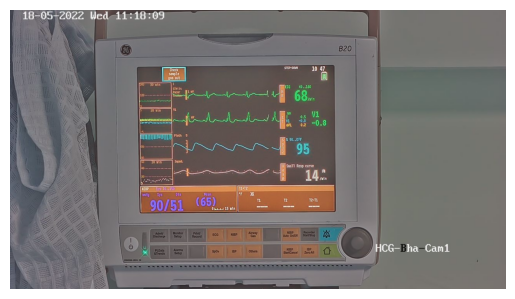

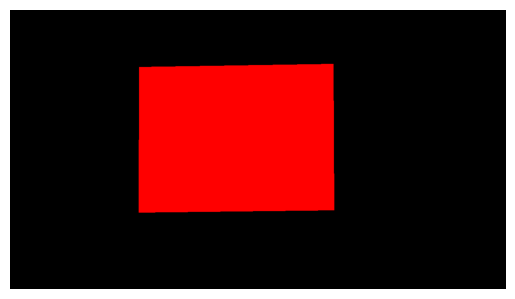

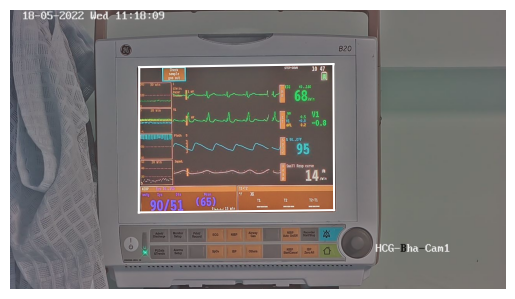

In [48]:
display_imgs('/kaggle/input/iitgai-ovha-23/images/hcgbhavnagar_micu_mon--403_2022_5_18_11_20_1.jpeg')

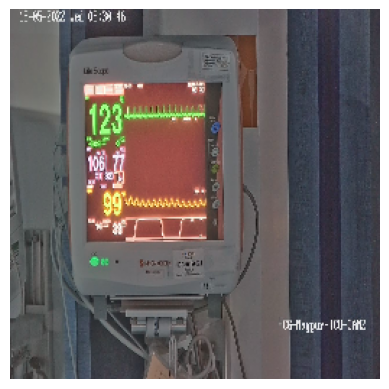

1/1 [==============================] - 0s 22ms/step


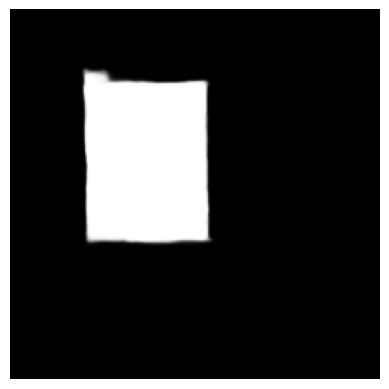

1/1 [==============================] - 0s 36ms/step


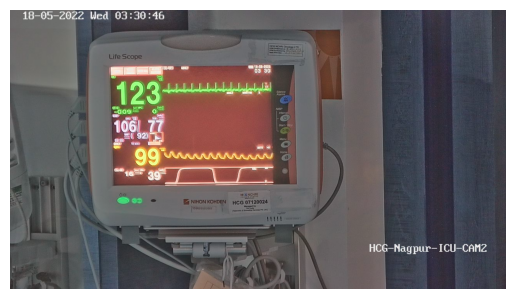

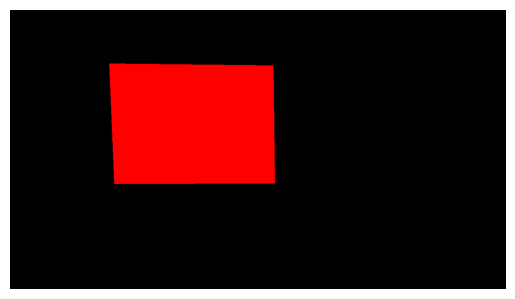

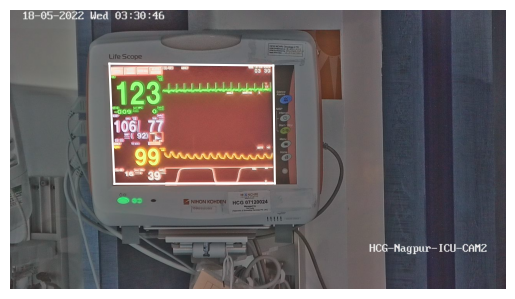

In [49]:
display_imgs('/kaggle/input/iitgai-ovha-23/test_images/hcgnagpur_icu_mon--3_2022_5_18_3_30_28.jpeg')

In [ ]:
import glob

path = '/kaggle/input/iitgai-ovha-23/test_images/*.jpeg'

fnames = []
predictions = []

for fname in glob.glob(path):
    img = cv2.imread(fname)
    img = cv2.resize(img, (SIZE,SIZE))
    img = img.astype(np.float32)
    img *= (1.0/255.0)
    img = img.mean(axis=2)
    img = np.expand_dims(img, axis=0)
    preds = model.predict(img)
    preds = preds[0]
    preds = np.expand_dims(preds, axis=0)
    arr_pred = cnn.predict(preds)
    arr = arr_pred[0]
    string = '['
    for val in arr : 
        string += str(int(float(val)))
        string += ','
    string = string[:-1]
    string += ']'
    print(string)
    fnames.append(fname)
    predictions.append(string)

In [ ]:
DF = pd.DataFrame()
DF['image_name'] = fnames
DF['points'] = predictions

In [ ]:
DF.to_csv('submission.csv', index=False)

In [ ]:
!cd /kaggle/working
!ls

In [ ]:
from IPython.display import FileLink
FileLink(r'UNET_Model_2.h5')